In [11]:
import matplotlib.pyplot as plt
import osmnx as ox

In [12]:
places = {
    "Dongcheng": "Dongcheng, Beijing, China",
    "Xicheng": "Xicheng, Beijing, China",
    "Chaoyang": "Chaoyang, Beijing, China",
    "Fengtai": "Fengtai, Beijing, China",
    "Shijingshan": "Shijingshan, Beijing, China",
    "Haidian": "Haidian, Beijing, China",
    "Mentougou": "Mentougou, Beijing, China",
    "Fangshan": "Fangshan, Beijing, China",
    "Daxing": "Daxing, Beijing, China",
    "Tongzhou": "Tongzhou, Beijing, China",
    "Shunyi": "Shunyi, Beijing, China",
    "Changping": "Changping, Beijing, China",
    "Huairou": "Huairou, Beijing, China",
    "Pinggu": "Pinggu, Beijing, China",
    "Miyun": "Miyun, Beijing, China",
    "Yanqing": "Yanqing, Beijing, China"
} # Beijing

In [13]:
places = {
    "Xuanwu": "Xuanwu, Nanjing, China",
    "Qinhuai": "Qinhuai, Nanjing, China",
    "Jianye": "Jianye, Nanjing, China",
    "Gulou": "Gulou, Nanjing, China",
    "Qixia": "Qixia, Nanjing, China",
    "Yuhuatai": "Yuhuatai, Nanjing, China",
    "Jiangning": "Jiangning, Nanjing, China",
    "Pukou": "Pukou, Nanjing, China",
    "Luhe": "Luhe, Nanjing, China",
    "Lishui": "Lishui, Nanjing, China",
    "Gaochun": "Gaochun, Nanjing, China",
    "Jiangbei": "Jiangbei, Nanjing, China",
} # Nanjing

In [14]:
gdf = ox.geocoder.geocode_to_gdf(list(places.values()))
gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((118.77866 32.09365, 118.77887 32.091...",118.778658,32.016819,118.903270,32.108297,204759561,relation,2138698,32.050677,118.792705,boundary,administrative,12,0.457146,city,Xuanwu District,"Xuanwu District, Nanjing City, Jiangsu, China"
1,"POLYGON ((118.75888 32.01452, 118.75914 32.014...",118.758881,31.976727,118.875600,32.044880,203206734,relation,2140011,32.041146,118.789603,boundary,administrative,12,0.457842,city,Qinhuai District,"Qinhuai District, Nanjing City, Jiangsu, China"
2,"POLYGON ((118.64716 31.97976, 118.64938 31.976...",118.647157,31.958249,118.763360,32.096968,204289426,relation,2139809,32.006384,118.727101,boundary,administrative,12,0.453320,city,Jianye District,"Jianye District, Nanjing City, Jiangsu, China"
3,"POLYGON ((118.71449 32.04519, 118.71839 32.043...",118.714490,32.030998,118.801643,32.133624,204179175,relation,2139790,32.069010,118.764773,boundary,administrative,12,0.460502,city,Gulou District,"Gulou District, Nanjing City, Jiangsu, China"
4,"POLYGON ((118.75985 32.20208, 118.76028 32.199...",118.759852,32.027523,119.239507,32.247062,203190452,relation,2140010,32.098543,118.904162,boundary,administrative,12,0.458951,city,Qixia District,"Qixia District, Nanjing City, Jiangsu, China"
5,"POLYGON ((118.58436 31.90818, 118.58667 31.905...",118.584358,31.867652,118.807804,32.016356,207895788,relation,2139830,31.993114,118.773958,boundary,administrative,12,0.451407,city,Yuhuatai District,"Yuhuatai District, Nanjing City, Jiangsu, China"
6,"POLYGON ((118.47566 31.78197, 118.4759 31.7807...",118.475656,31.620869,119.115257,32.110898,208536770,relation,2147642,31.955218,118.834820,boundary,administrative,12,0.469857,city,Jiangning District,"Jiangning District, Nanjing City, Jiangsu, China"
7,"MULTIPOLYGON (((118.33459 31.95435, 118.33469 ...",118.334591,31.842976,118.773875,32.253282,204540588,relation,2124188,32.061636,118.622089,boundary,administrative,12,0.463351,city,Pukou District,"Pukou District, Nanjing City, Jiangsu, China"
8,"POLYGON ((118.55803 32.56712, 118.55936 32.564...",118.558030,32.167162,119.074760,32.615778,204526713,relation,2131458,32.325294,118.816457,boundary,administrative,12,0.455786,city,Luhe District,"Luhe District, Nanjing City, Jiangsu, 210044, ..."
9,"MULTIPOLYGON (((118.82815 31.63658, 118.829 31...",118.828152,31.381037,119.232001,31.792597,208716325,relation,2147643,31.650688,119.026240,boundary,administrative,12,0.450697,city,Lishui District,"Lishui District, Nanjing City, Jiangsu, 211200..."


<Axes: >

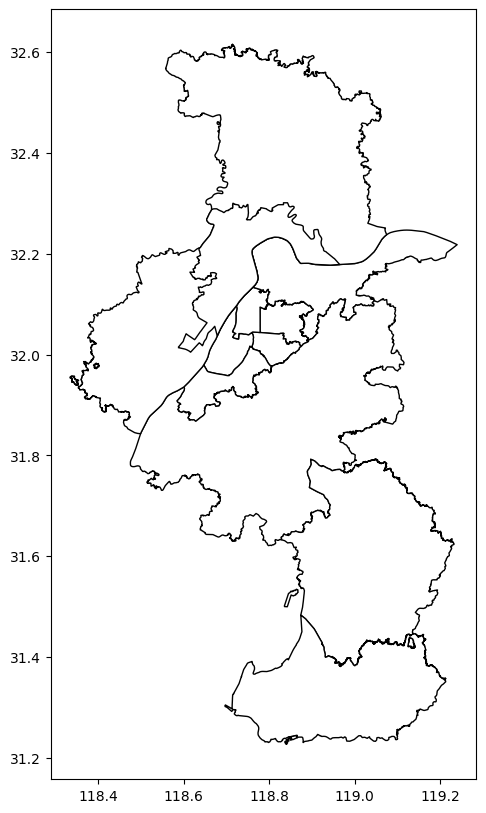

In [15]:
gdf.plot(color="white", edgecolor="black", figsize=(10, 10))

In [16]:
# fetch the street network for each city
street_graphs = {}
for place in places:
    print(ox.utils.ts(), place)
    street_graphs[place] = ox.graph.graph_from_place(places[place], network_type="drive")


2025-04-18 15:09:04 Xuanwu
2025-04-18 15:09:05 Qinhuai
2025-04-18 15:09:06 Jianye
2025-04-18 15:09:07 Gulou
2025-04-18 15:09:08 Qixia
2025-04-18 15:09:11 Yuhuatai
2025-04-18 15:09:13 Jiangning
2025-04-18 15:09:19 Pukou
2025-04-18 15:09:22 Luhe
2025-04-18 15:09:25 Lishui
2025-04-18 15:09:28 Gaochun
2025-04-18 15:09:29 Jiangbei


In [17]:
import math
def primary_angle(angle):
    if angle > 180:
        return angle - 180
    elif angle < 0:
        return angle + 180
    return angle

def calc_entropy(angles, bins=18):
    counts = [0 for _ in range(bins)]
    for angle in angles:
        a = int(angle-0.0001) // (180 // bins)
        counts[a] += 1
    # print('counts', counts)

    entropy = 0
    for i, cnt in enumerate(counts):
        entropy -= cnt/sum(counts) * math.log(cnt / sum(counts))
    return entropy


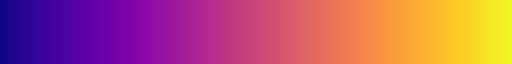

In [18]:
plt.get_cmap('plasma')

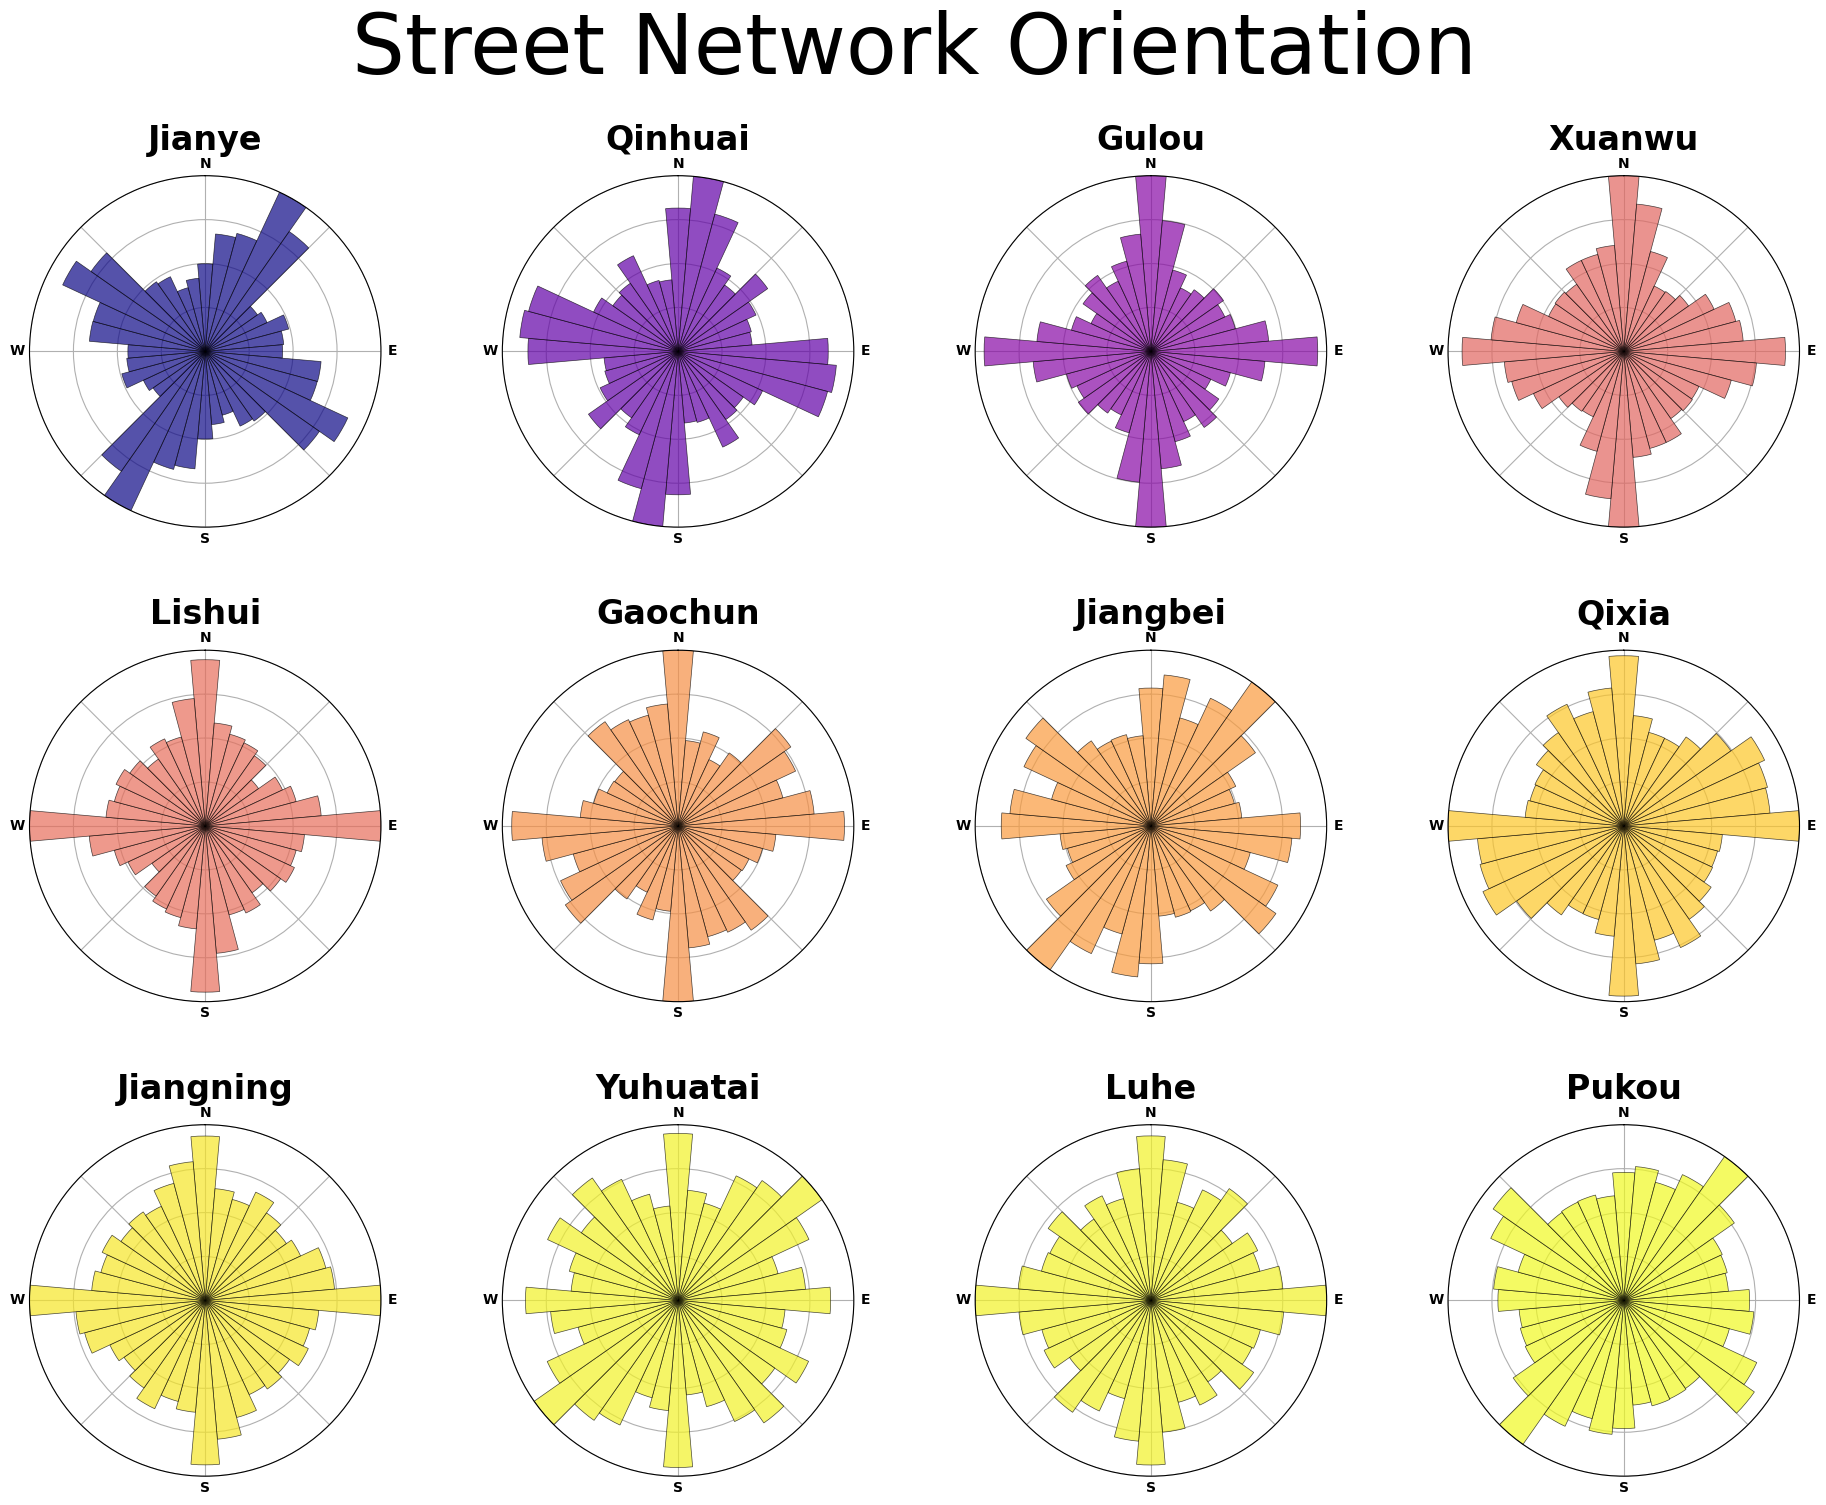

In [19]:
n = len(places)
ncols = 4
nrows = (len(places)+3)//ncols
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={"projection": "polar"})

# plot each city's polar histogram
Gus = []
for i, place in enumerate(places):
    ax = axes.flat[i]
    G = street_graphs[place]
    Gu = ox.bearing.add_edge_bearings(ox.convert.to_undirected(G))

    angles = [primary_angle(d['bearing']) for _, _, _, d in Gu.edges(keys=True, data=True) if 'bearing' in d]

    Gus.append((calc_entropy(angles), place, Gu))

Gus = sorted(Gus, key=lambda x: x[0], reverse=True)
# norm = plt.Normalize(2, 3)
norm = plt.Normalize(Gus[-1][0], Gus[0][0])
cmap = plt.get_cmap('plasma')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i, (entropy, place, gu) in enumerate(Gus):
    ax = axes.flat[nrows*ncols-i-1]
    fig, ax = ox.plot.plot_orientation(gu, ax=ax, title=place, area=True, color=cmap(norm(entropy)))

# add figure title and save image
suptitle_font = {
    "family": "DejaVu Sans",
    "fontsize": 60,
    "fontweight": "normal",
    "y": 1,
}
fig.suptitle("Street Network Orientation", **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
plt.show()

(118.289344685, 119.284752615, 31.157296185, 32.685229514999996)

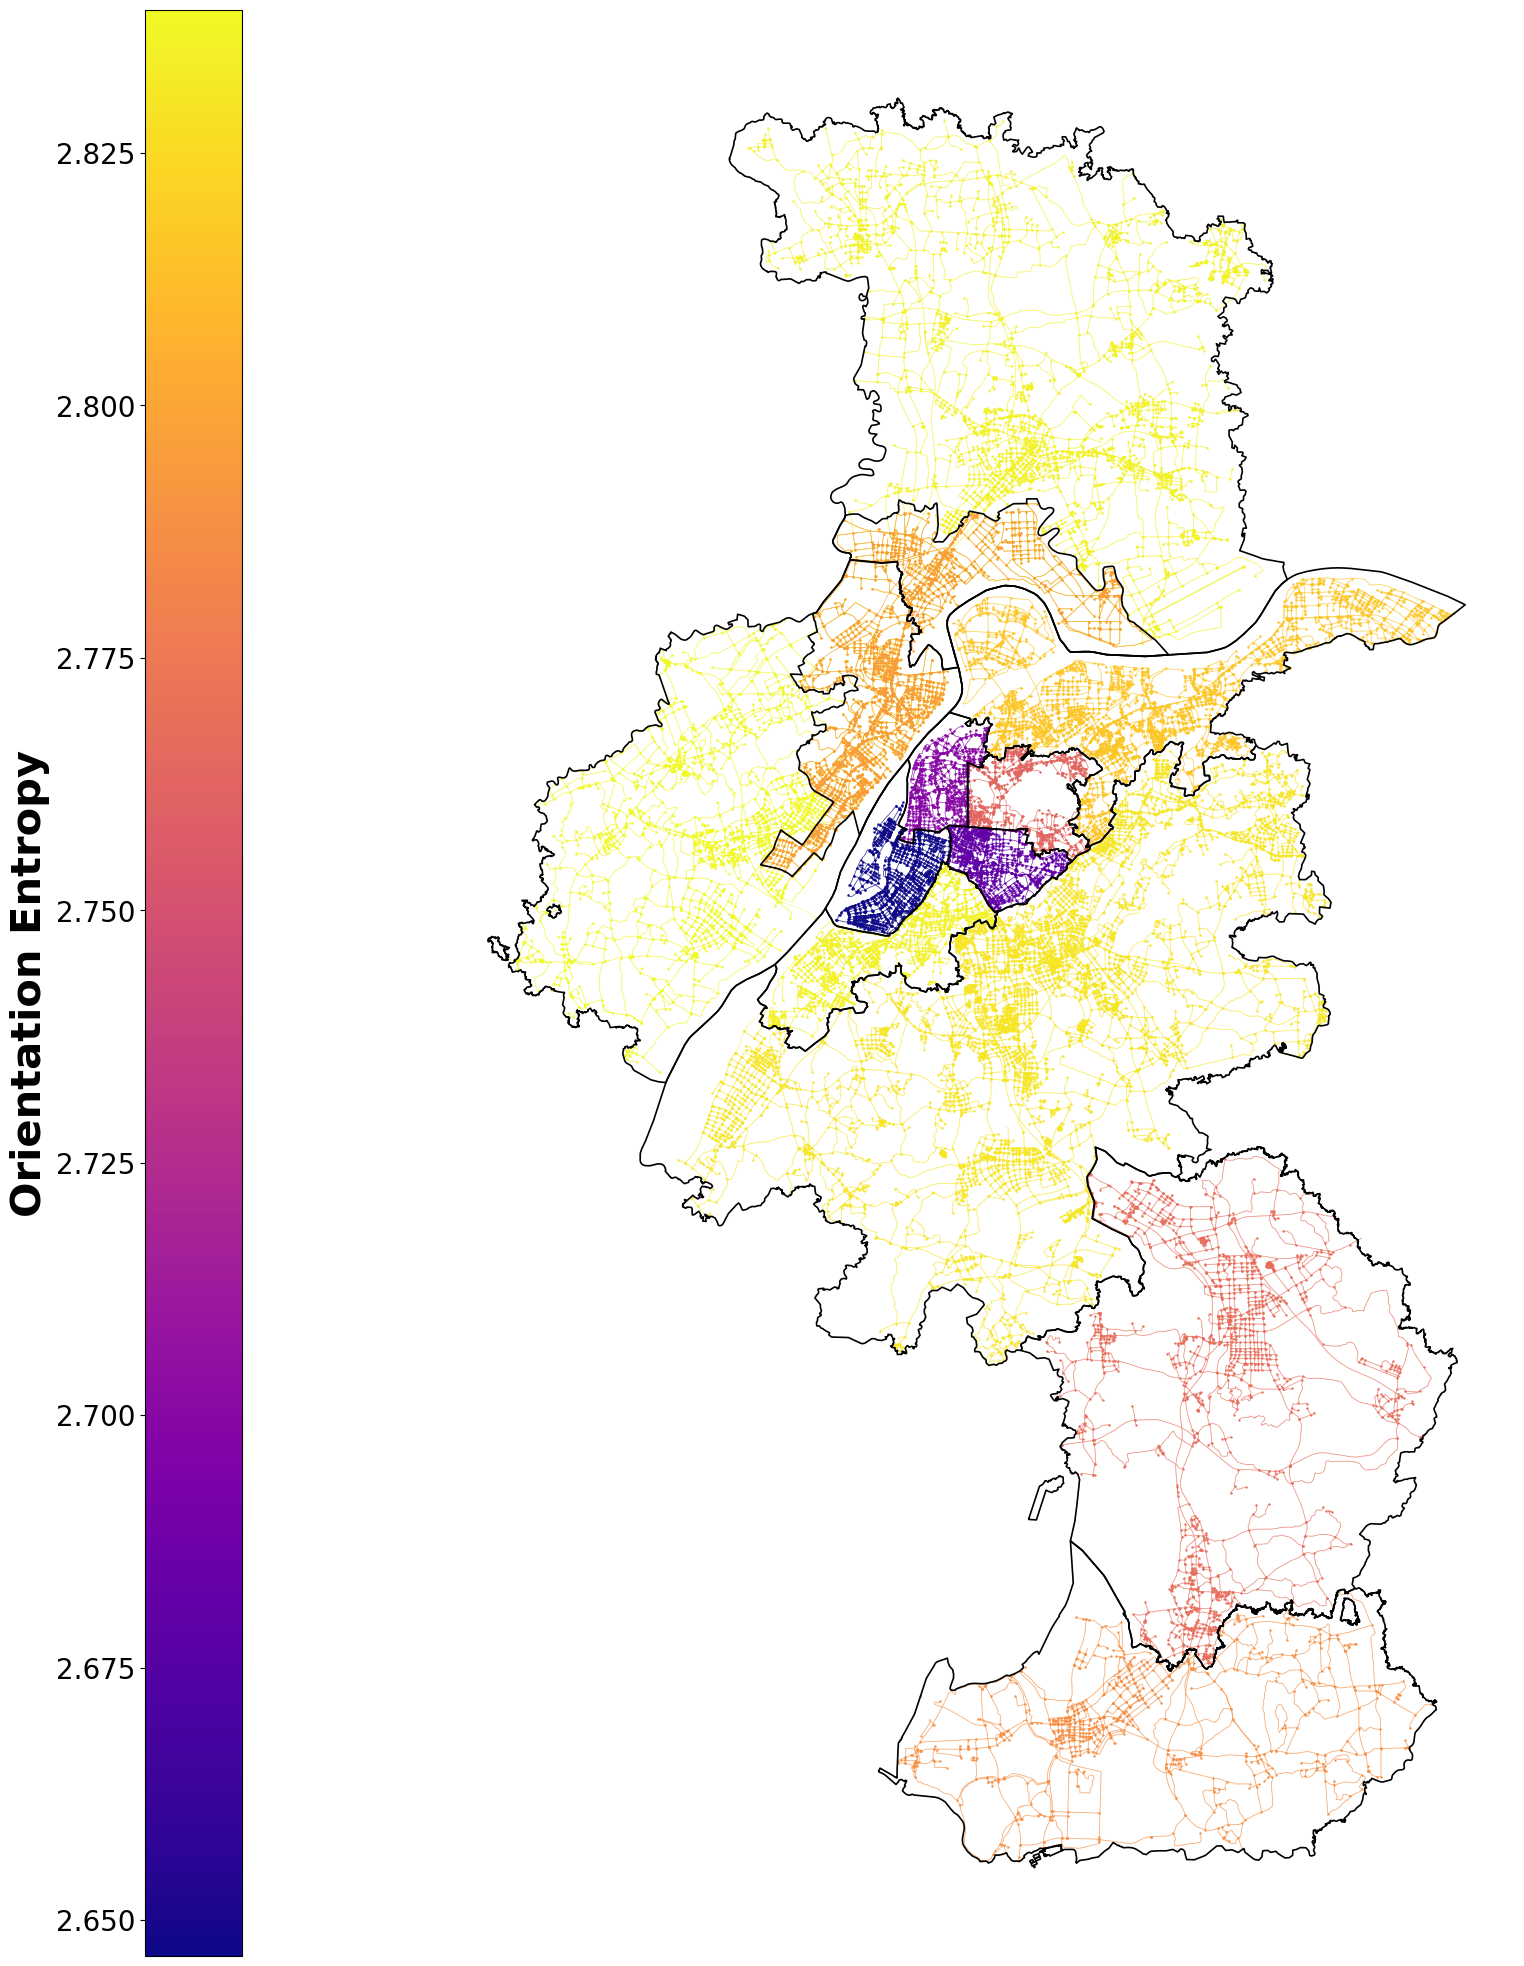

In [20]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf.plot(ax=ax, color="none", edgecolor='k', linewidth=1.2, zorder=10)

for i, (entropy, place, _) in enumerate(Gus):
    color = cmap(norm(entropy))
    gdf_edges = ox.convert.graph_to_gdfs(street_graphs[place], nodes=False)["geometry"]
    gdf_edges.plot(ax=ax, color=color, linewidth=0.5, alpha=0.5)
    gdf_nodes = ox.convert.graph_to_gdfs(street_graphs[place], edges=False, node_geometry=False)[["x", "y"]]
    ax.scatter(x=gdf_nodes["x"], y=gdf_nodes["y"], color=color, zorder=2, s=0.5)

fig.tight_layout()
fig.subplots_adjust(hspace=0.35)

sm.set_array([])
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'DejaVu Sans',
    'font.weight': 'normal',
})
cbar = fig.colorbar(sm, ax=ax, location='left')
cbar.set_label("Orientation Entropy", fontsize=30, fontweight='bold')
plt.axis("off")
# fig.savefig("orientation_entropy.png", bbox_inches='tight')
